<h1>Poles/Zeros/Gain from Look-Up Tables (Prototyping)</h1>

## Problem Statement

The IRIS metadata archiving process had a strong preference for pole-zero ('zpk') representations of analog filters.  However, calibrations of many MT instruments are characterized in the form of frequency sweeps, and the manufacturers calibrations are often provided in terms of tables of frequency, with amplitude and phase responses ('fap'). 

Thus we are faced with the problem of expressing a generic _fap_ instrument resposne in the _zpk_ format.

## Inverse Problem Setup

$\bf{d}$: The "data" in the the 'fap' table.  This is simply a set of $N$ ordered pairs, $\{(f_1, x_1), (f_2, x_2), ... (f_N, x_N)\}$ where $f_i \in \mathbb{R}^+$ and $x_i \in \mathbb{C}$

$\bf{G}$: The function relating the data and the model can take on several parameterizations.  One of the parameterizations is as a ratio of real valued polynomials:

$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} $

Where the Laplace variable _s_  = *j* $\omega$


$\bf{m}$:  Using the above parameterization $\bf{m}$ would be the set of $m + n + 2$ coefficients ${a_0, a_1, ...a_m, b_0, b_1, ... b_n}$ with $a_i, b_i \in \mathbb{R}$

<br>
<br>

The coefficients in the numerator and denominator polynomials in the Laplace domain representation of the filter are real. They typically correspond to values of circuit parameters resistance, capacitance, inductance, etc. in analog EE applications. This means that these polynomials factor completely over the complex plane and moreover, the roots are either real or occur in complex-conjugate pairs.
<br>
<br>

Factoring $h(s)$ on top and bottom yields the form:

$ \displaystyle h (s) = k  \frac{(s-z_1)(s-z_2)...(s-z_m) }{(s-p_1)(s-p_2)...(s-p_n)} $

There are well defined transformations between these representations and they are available through _scipy.signal.tf2zpk_ or _zpk2tf_.


### Recent Activity in PZ-fitting

Ben Murphy tried a variety of methods to solve this problem but invariably wound up encountering poles and zeros (roots) that did not obey the principle of complex-conjugate roots, and  sometimes poles on the right hand side of the plane, and or k values that were complex-valued.  The complex k values are particularly concerning because IRIS does not provide support for complex-valued k -- it is just one double-precision number.  

The reason for these issues deserves some analysis but at a high level seems to be due to parameterizations that ultimately wound up searching complex-valued spaces for soltuions.

Karl tried some variants on Ben's methods which involved some regularization functions that penalized non-conjugate root pairs, and imaginary parts of k, but these never matured so their value is questionable.

It seems like we should be able to use a numeric method to solve in the real valued form (even though the evaluation of the TF is Complex, the coefficients are real) and then extract the zpk afterwards.  Following is an example of a numeric solution.





In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from matplotlib.gridspec import GridSpec
from pathlib import Path
from scipy import signal
from scipy.optimize import minimize

from mt_metadata.timeseries.filters.plotting_helpers import plot_response
from aurora.sandbox.plot_helpers import plot_complex_response

# from regularization_function_development import add_regularization_term 
# from regularization_function_development import get_pz_regularization

# %matplotlib inline


In [46]:
DEG2RAD = np.pi/180

## Load the data from data repo

In [47]:
calibration_file_path = Path("Lemi-039_N131BxByBz", "Lemi-039_N131.cal")

df = pd.read_csv(calibration_file_path, skiprows=3, delimiter='\t')
column_labels = ['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y', 'amplitude_z', 'phase_z']
columns_map = dict(zip(df.columns, column_labels))
df = df.rename(columns=columns_map)
print(df.columns)


Index(['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y',
       'amplitude_z', 'phase_z'],
      dtype='object')


## Preliminary Response Curve

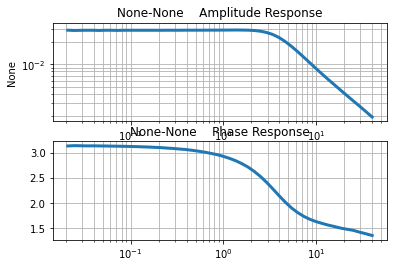

In [48]:
x_phase_radians = DEG2RAD*df['phase_x']
x_phasor = np.exp(1.J*x_phase_radians) #(np.cos( x_phase_radians)+ 1.j*np.sin(x_phase_radians))
x_complex_response = df['amplitude_x'] * x_phasor
X_COMPLEX_RESPONSE = x_complex_response #make it global for availabilty in objective functions
frequencies = df['frequency'].to_numpy()

plot_complex_response(df['frequency'], x_complex_response)

## Estimate the response amplitude in the pass band

In [49]:
nominal_passband_response_amplitude = df['amplitude_x'].iloc[10].mean()
print('nominal_passband_response_amplitude', nominal_passband_response_amplitude)

nominal_passband_response_amplitude 0.02847


## Express in units of deciBels and plot on semilog

In [50]:
amplitude_in_db = 20*np.log10(df['amplitude_x']/nominal_passband_response_amplitude)

Text(0.5, 1.0, 'Amplitude Response of Instrument in dB')

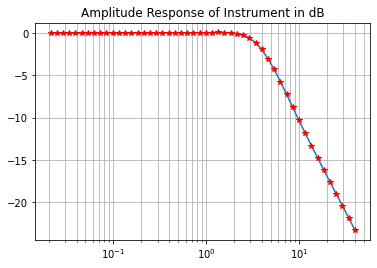

In [51]:
plt.semilogx(df['frequency'], amplitude_in_db)
plt.semilogx(df['frequency'], amplitude_in_db, 'r*')
plt.grid(which='both')
plt.title('Amplitude Response of Instrument in dB')


## Note that the decay is log-linear after about 5Hz

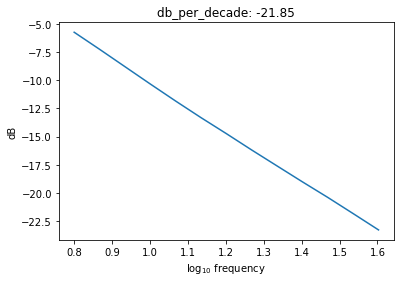

In [53]:
#The last 13 points are approximately a straight line on the log plot
n_asymptotic_log_linear = 13
frq_line = df['frequency'][-n_asymptotic_log_linear:]
ampl_line = df['amplitude_x'][-n_asymptotic_log_linear:]
db_line = amplitude_in_db[-n_asymptotic_log_linear:]
log_f = np.array(np.log10(frq_line))
log_a = np.array(np.log10(ampl_line))
db = np.array(db_line)
db_per_decade = (db[-1]-db[0]) / (log_f[-1]-log_f[0])

plt.plot(log_f, db_line)
plt.xlabel('log$_{10}$ frequency')
plt.ylabel('dB')
plt.title(f"db_per_decade: {db_per_decade:.2f}")
plt.show()

### looks like approximately -20dB/decade, which theoretically corresponds to a single pole.  We obtain a decent fit with one pole, but a better fit with 3poles and one zero.

If we want to optimize we need to add constraints however.  In particular, a regulariization that forces 1: complex poles to be conjugates, and the 'odd' poles to be pure real.  This means modifying the LLSQ process.

If the roll off is ~20dB/ decade then we would expect a 1 pole filter, or at least a filter with one more pole than zeros

In [71]:
%%html
<iframe src="https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Electronics/Operational_Amplifiers_and_Linear_Integrated_Circuits_-_Theory_and_Application_(Fiore)/11%3A_Active_Filters/11.04%3A_Section_4-" width="1200" height="1000"></iframe>

In [55]:
# from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LLSQ
# n_zeros = 2; n_poles = 3;
# #n_zeros = 0; n_poles = 1;

# print("PARAMETERIZATION: {} zeros, {} poles".format(n_zeros, n_poles))
# w_obs = 2*np.pi*frequencies
# resp_obs =  x_complex_response#df['amplitude_x']
# LEMI_LM_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(w_obs, 
#                                                         resp_obs, 
#                                                         n_zeros, n_poles, useSKiter=False, 
#                                                          regularize=False)
# print(LEMI_LM_ZPK)

# plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
#               zpk_pred=LEMI_LM_ZPK, w_values=w_obs)


### Lets try a numerical approach using scipy optimize and some regularization that penalizes deviations from the fundamental theorem of algebra solutions

In [103]:
W = 2*np.pi*frequencies

N_ZEROS = 0; N_POLES = 1 #Not great
N_ZEROS = 1; N_POLES = 2#Good when seeded with 1
#N_ZEROS = 2; N_POLES = 3#Good when seeded with 3
#N_ZEROS = 3; N_POLES = 4#not so good
np.random.seed(1)
b0 = np.random.rand(N_ZEROS+1)
a0 = np.random.rand(N_POLES+1)

MODEL_VECTOR_0 = np.hstack((b0, a0))
#print('MODEL_VECTOR_0',MODEL_VECTOR_0)


def objective_function(model_vector, verbose=False):
    #unpack the model vector
    bb = model_vector[:N_ZEROS+1]
    aa = model_vector[N_ZEROS+1:]
    
    if verbose:
        print('numerator ', bb, N_ZEROS)
        print('denominator', aa, N_POLES)
    w, h = signal.freqs(bb, aa, worN=W)
    residual = X_COMPLEX_RESPONSE - h
    #print(residual)
    misfit = np.sqrt(np.mean(np.abs(residual**2)))
#    misfit = add_regularization_term(zeros, poles, k, misfit, aa=0.1)
    if verbose:
        print('misfit',misfit)
    return misfit

objective_function(MODEL_VECTOR_0, verbose=True)

numerator  [ 0.417022    0.72032449] 1
denominator [  1.14374817e-04   3.02332573e-01   1.46755891e-01] 2
misfit 2.46055330257


2.4605533025729578

In [104]:
#method = 'nelder-mead'
method = 'Powell'
#method = 'CG'
#method = 'Newton-CG' #needs Jacobian
res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })

/home/kkappler/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: OptimizeWarning: Unknown solver options: xatol
  """


Optimization terminated successfully.
         Current function value: 0.000202
         Iterations: 14
         Function evaluations: 1089


In [105]:
res.x
bb = res.x[:N_ZEROS+1]
aa = res.x[N_ZEROS+1:]
zpk = signal.TransferFunction(bb, aa).to_zpk()
#zpk = signal.tf2zpk(bb, aa)
print(zpk)
#print(type(zpk))


ZerosPolesGainContinuous(
array([-37.78764719]),
array([-18.49867054+16.57300946j, -18.49867054-16.57300946j]),
-0.4648829833859911,
dt: None
)


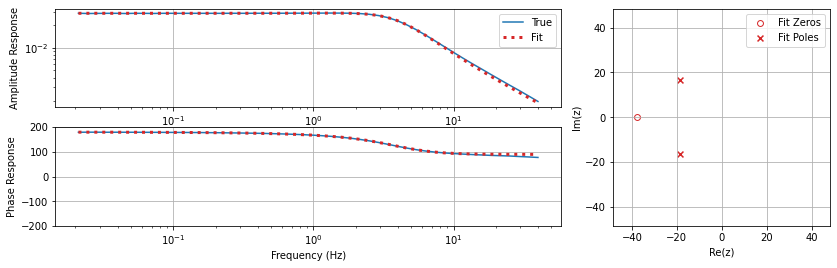

In [106]:
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=zpk, w_values=w_obs)

what percent differences are we looking at here?

In [112]:
resp_obs
frequencies
w_pred, resp_pred = signal.freqresp(zpk, w=w_obs)
np.abs((resp_pred-resp_obs)/resp_obs)*100

(1./DEG2RAD)*(np.angle(resp_pred) - np.angle(resp_obs))/np.angle(resp_obs)

array([  1.17108509e-01,  -8.15728192e-03,   8.01752757e-03,
         4.71400215e-02,   3.37596502e-03,   7.12834007e-03,
         6.71110507e-03,   1.74167859e-02,   9.65177288e-03,
         4.83541843e-03,   5.07153821e-03,  -1.01671816e-02,
        -7.34773273e-04,  -1.01214521e-02,   1.32071422e-03,
        -1.38925629e-02,   1.55362896e-02,  -1.14290846e-03,
         1.29174179e-02,  -2.86266283e-02,  -1.09777128e-02,
         3.26699526e-03,  -1.59316504e-03,   1.97338839e-02,
        -1.73524258e-02,   3.47419521e-04,   1.98501572e-02,
         1.77932781e-02,   5.45075830e-02,   5.87195330e-02,
         1.15844367e-01,   1.43397591e-01,   1.63482792e-01,
         1.53176575e-01,   1.34203539e-01,   4.45630958e-02,
        -2.04469810e-02,  -1.11298669e-01,  -4.75105695e-02,
         1.52755963e-01,   4.38486018e-01,   8.40064153e-01,
         1.48316739e+00,   2.17213577e+00,   3.13772873e+00,
         3.86222759e+00,   4.70537812e+00,   6.19387338e+00,
         7.59606740e+00,

In [102]:
frequencies[40]

10.007999999999999

## So, where are we?

We have a numeric method that works "pretty  well" but could use some serious tuning
1. We have analytic expressions so lets get some Jacobians and Hessians and try some of the more classical approaches in scipy.minimize

2. Lets try a bunch of seed values for each optimization and explore the sum RMS misfits.  
3. Do (2) above for a collection of n_poles, n_zeros controls

4. Tidy up supporting codes and make some metrics/reports to use for these fits
5. Move on

####  Note that if we relax the requirement that the poles and zeros are real or conjugate-pairs we can get better fits, but it is a physical solution.  There is some research to be done here.  

If you are interested in exploring more check out Ben Murphy's ipynb in iris-mt-scratch repo

In [62]:
from scipy.optimize import minimize

PARAMETERIZATION: 2 zeros, 3 poles
ZerosPolesGainContinuous(
array([-957.08603092+4.45450947j,  -34.98372872-2.28826934j]),
array([-485.28932769+107.50895551j,  -17.26778927 -17.54658073j,
        -18.34527168 +15.52113528j]),
(-0.2446806069717897+0.046680268003547215j),
dt: None
)


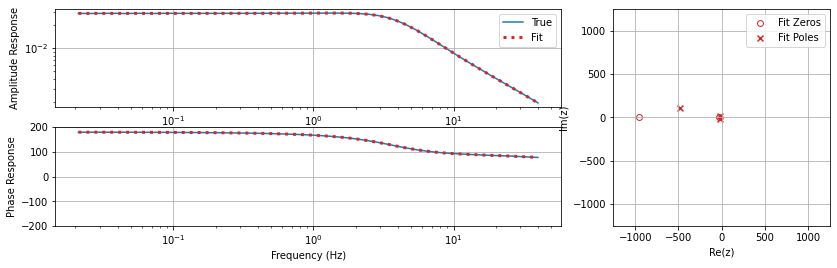

In [95]:
from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LLSQ
n_zeros = 2; n_poles = 3;
#n_zeros = 1; n_poles = 2;
#n_zeros = 0; n_poles = 1;

print("PARAMETERIZATION: {} zeros, {} poles".format(n_zeros, n_poles))
w_obs = 2*np.pi*frequencies
resp_obs =  x_complex_response#df['amplitude_x']
LEMI_LM_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(w_obs, 
                                                        resp_obs, 
                                                        n_zeros, n_poles, useSKiter=False, 
                                                         regularize=False)
print(LEMI_LM_ZPK)

plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)


In [113]:
w_pred, resp_pred = signal.freqresp(LEMI_LM_ZPK, w=w_obs)
np.abs((resp_pred-resp_obs)/resp_obs)*100

0     0.638158
1     0.498207
2     0.101776
3     0.207398
4     0.135960
5     0.449954
6     0.155934
7     0.114567
8     0.313557
9     0.112989
10    0.140235
11    0.169018
12    0.100383
13    0.119354
14    0.068533
15    0.090453
16    0.157084
17    0.072294
18    0.092330
19    0.203936
20    0.074840
21    0.081134
22    0.056017
23    0.159542
24    0.163991
25    0.120231
26    0.181844
27    0.074201
28    0.132750
29    0.129995
30    0.070027
31    0.102507
32    0.089862
33    0.195729
34    0.245377
35    0.179085
36    0.213835
37    0.064805
38    0.141571
39    0.163369
40    0.292033
41    0.388454
42    0.113458
43    0.268236
44    0.535032
45    0.112583
46    0.439616
47    0.208596
48    0.043306
49    0.037117
dtype: float64